# `Prophet Article` 

Prophet model uses a human interpretable elements to forecast time series data. It is a decomposable time series model with three main components: trend, seasonality, and holidays. The model is based on an additive model, which means that the components are added together. The model is defined as follows:

$$
y(t) = g(t) + s(t) + h(t) + \epsilon_t \\[0.5cm]
\text{where:} \\[0.5cm]
g(t) = \text{trend component that models non-periodic changes in the value of time series} \\[0.3cm]
s(t) = \text{seasonality component that models periodic changes in the value of time series} \\[0.3cm]
h(t) = \text{holiday component that models the effect of holidays on the time series} \\[0.3cm]
\epsilon_t = \text{error term, assumed to be normally distributed}
$$

This specication is similar to a generalized additive model (GAM), which may have  non-linear smoothers applied to the regressors. Conversely, in the baseline Prophet model they use "only time as a regressor but possibly several linear and non-linear functions of time as components" (Taylor & Letham, 2017).

The Prophet model frames the forecasting problem as fitting a curve to the data, which is different from other time series models which account for the temporal relationships between observations. 

While removing inferential advantages of generative models such as ARIMA, which is formulated as follows:

$$
y(t) = \phi_1 y(t-1) + \phi_2 y(t-2) + \ldots + \phi_p y(t-p) + \epsilon_t, \quad \epsilon_t \sim N(0, \sigma^2) \\[0.3cm]
$$

ARIMA uses the moving average of the time series to forecast future values, while Prophet focuses on the trend, seasonality, and holidays, in a piecewise linear or logistic growth curve.

This approach provides pratical advantages (Taylor & Letham, 2017):

- Flexibility: the model can capture seasonality with multiple periods and let the human make different assumptions about trends.

- Unlike ARIMA models, the measurements do not need to be regularly spaced,
 and we do not need to interpolate missing values after removing outliers for example

 - Fitting is very fast

 - The forecasting model has easily interpretable paramete. Moreover, extending the model to include new components is easy.


## The trend component

### 1. Nonlinear, Saturating Growth

Intened for growth forecasting. The core component here is a model for how the population has grown and how it is expected to continue growing. In its most basic form, the growth (trend) component is modeled as a saturating growth curve, which is a logistic growth curve. The logistic growth curve is defined as:

$$
g(t) = \frac{C}{1 + \exp(-k(t - m))} \\[0.3cm]
\text{where:} \\[0.3cm]
C = \text{carrying capacity} \\[0.3cm]
k = \text{growth rate} \\[0.3cm]
m = \text{offset parameter}
$$


**C -** Not a constant as the number of people in the world who have access to the Internet increases, so does the growth ceiling.Therefore, the capacity C becomes a time-varying capacity C(t). 

**k-** Not a constant. The model must be able to incorporate a varying rate.
The model incorporates trend changes in the growth model by explicitly defining changepoints where the growth rate is allowed to change. Concisely, it's defined as:

$$
k^*(t) = \begin{cases}
k + \sum_{j:t>s_j} \delta_j, & \text{if } t  \geq s_j \\
k, & \text{else}
\end{cases} \\[0.3cm]
\text{where:} \\[0.3cm]
\delta_j = \text{change in growth rate at changepoint } s_j
$$

**m-** The offset parameter is also adjusted at the t changepoints, to connect the endpoints of the segments. The adjusted is defined as:

$$
\gamma_j = \begin{cases}
(s_j - m + \sum_{l<j} \gamma_l) \cdot (1- \frac{k+\sum_{l < j} \delta_l}{k+\sum_{l \leq j} \delta_l}), & \text{if } t  \geq s_j \\
m, & \text{else}
\end{cases} \\[0.3cm]
$$

For easier formulation we'll define $a_j(t)$:

$$
a_j(t) = \begin{cases}
1, & \text{if } t \geq s_j \\
0, & \text{else}
\end{cases} \\[0.3cm]
$$

Then, the **piecewise logistic growth** rate can be written as:

$$
g(t) = \frac{C(t)}{1 + \exp(-(k + a(t)^T \delta)(t - (m + a(t)^T \gamma)))}
$$



### 2. Linear Trend with Changepoint

For forecasting problems that **don't** exhibit saturating growth, a piece-wise constant rate of growth provides a parsimonious and often useful model. Here, the trend model is defined as:

$$
g(t) = (k + a(t)^T \delta) \cdot t + (m + a(t)^T \gamma) \\[0.3cm]
\text{Where here we define } \gamma_j \text{as:}\\[0.3cm]
\gamma_j = -s_j \delta_j, \quad \text{To make the function continuous at the changepoints}
$$

### Automatic Changepoint Selection

The changepoints can be specified using known dates or by specifying the number of changepoints to find or candidates. Automatic selection can be done naturally using sparse prior for $\delta$. Common method is specifying a large numver of changepoints and use prior $\delta_j \sim Laplace(0, \tau)$, where $\tau$ is a hyperparameter that controls the sparsity of the changepoints, as tau goes to zero, the model becomes a linear model. Note: $\delta$ has no effect on the growth rate k.

### Let's plot laplace and see the sparsity:

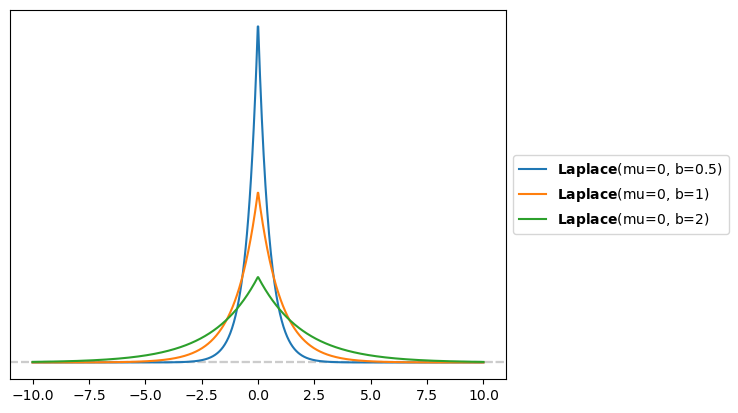

In [12]:
## Double Exponential Distribution
import preliz as pl
from preliz import Laplace
#plot laplace with mean 0 and tau 0.5
tau_values = [0.5, 1, 2]
for tau in tau_values:
    Laplace(0, tau).plot_pdf(support=(-10, 10))


We can see that as tau becomes smaller the $\delta$ values tend to go to 0 and we get reduced to a standard (not piecewise) linear or logistic model.

### Trend Forecast Uncertainty

 When the model is extrapolated past the history to make a forecast, the trend will have a constant rate. The model estimates forecast uncertainty in the forecast trend by extending the generative model forward. The generative model for the trend is that there are S changepoints over
 a history of T points, each of which has a rate change of $\delta_j$. 

 The model simulates future rate changes that emulate those of the past by replacing $\tau$ with a variance inferred from data. In a fully Bayesian- a hierarchical prior on $\tau$ to obtain its posterior, otherwise -use the maximum likelihood estimate of the rate scale parameter: 

 $$
\lambda = \frac{1}{S} \sum_{j=1}^S |\delta_j|
 $$

 We procceed by sampling $\delta_j$:

 $$
\begin{cases}
\delta_j = 0 , & w.p. \quad \frac{T-S}{T} \\
\delta_j \sim Laplace(0, \lambda), & w.p. \quad \frac{S}{T}
\end{cases}
 $$

The model measures **uncertainty** in the forecast trend by assuming that the future will see the **same** average frequency and magnitude of **rate changes** that were seen in the history. Once $\lambda$ has been inferred from the data, we use this generative model to simulate possible future trends and use the simulated trends to compute uncertainty intervals. We do not expect the uncertainty intervals to have exact coverage. They are, however, a useful indication of the level of uncertainty, and especially an indicator of **overfitting**. As $\tau$ is increased the model has more
flexibility in fitting the history and so training error will drop. However, when projected forward this exibility will produce *wide* uncertainty intervals.

## The Seasonality Component

We assume periodic changes in the value of the time series. One great way to model periodic effects is to use Fourier series. The Fourier series is a way to represent any periodic function as a sum of sine and cosine functions. The model is defined as:

$$
s(t) = \sum_{n=1}^N (a_n \cos(2\pi nt/P) + b_n \sin(2\pi nt/P)) \\[0.3cm]
\text{where:} \\[0.3cm]
P - \text {Regular period we expect to see in the data, e.g. P = 365.25 for yearly data} \\[0.3cm]
$$

Fitting Seasonality requires 2N parameters, $\beta = [a_1, b_1, \ldots, a_N, b_N]^T$, which can be done using a Seasonality matrix. For example for yearly seasonal data with N = 10, the matrix would look like:

$$
X(t) = \left[ cos(2\pi \cdot 1 t / 365.25), sin(2\pi \cdot 1 t / 365.25), \ldots, cos(2\pi \cdot 10 t / 365.25), sin(2\pi \cdot 10t / 365.25) \right]
$$

and the Seasonal component would be $s(t) = X(t) \beta$.

We're sampling $\beta \sim N(0, \sigma^2 I)$, which acts as a smoothing prior. The model can also handle multiple seasonalities by adding more Fourier terms.

Increasing N provides fitting more changes in the seasonality, but also increases the risk of overfitting. they found that for yearly and weekly N =10 and N = 3 respectively are good starting points. You can automate the choice of N by using model selection with AIC.

## The Holiday Component

You can custom the holidays and events nserted into the model. The Holiday component is defined with indicator as:

$$
Z(t) = [\mathbb{1}(t \in H_1), \ldots, \mathbb{1}(t \in H_L)] \\[0.3cm]
\text{And multiplied by a coefficients of chnge in forecast:} \\[0.3cm]
h(t) = Z(t) \kappa \\[0.3cm]
\text{Where:} \\[0.3cm]
\kappa - \text{corresponding change in forecast per holiday}
$$

Like in Seasonality we use a prior $\kappa \sim N(0, \nu^2)$, which acts as a smoothing prior. The model includes additional parameters for the days surrounding the holiday, to account for the fact that a holiday affects the days around it, effectively treating neighboring days as holidays. 

## Fitting the model

We first combine the Seasonality and Holiday features for each observation into a matrix X and the changepoint indicator a(t) into a matrix A. Then we find maximum a posteriori (MAP) estimates [$\delta, \gamma, \beta, \tau, \sigma, \nu$] which maximize the likelihood function:

For Logistic trend:

$y \sim \text{Normal}(\frac{C}{1 + \exp(-(k + A \cdot \delta))} \cdot (t - (m + A \cdot \gamma)) + X(t) \beta + Z(t) \kappa, \epsilon)$

For Linear trend:

$y \sim \text{Normal}((k + A \cdot \delta) \cdot t + (m + A \cdot \gamma) + X(t) \beta, \sigma)$

## Other Baseline models for comparison:

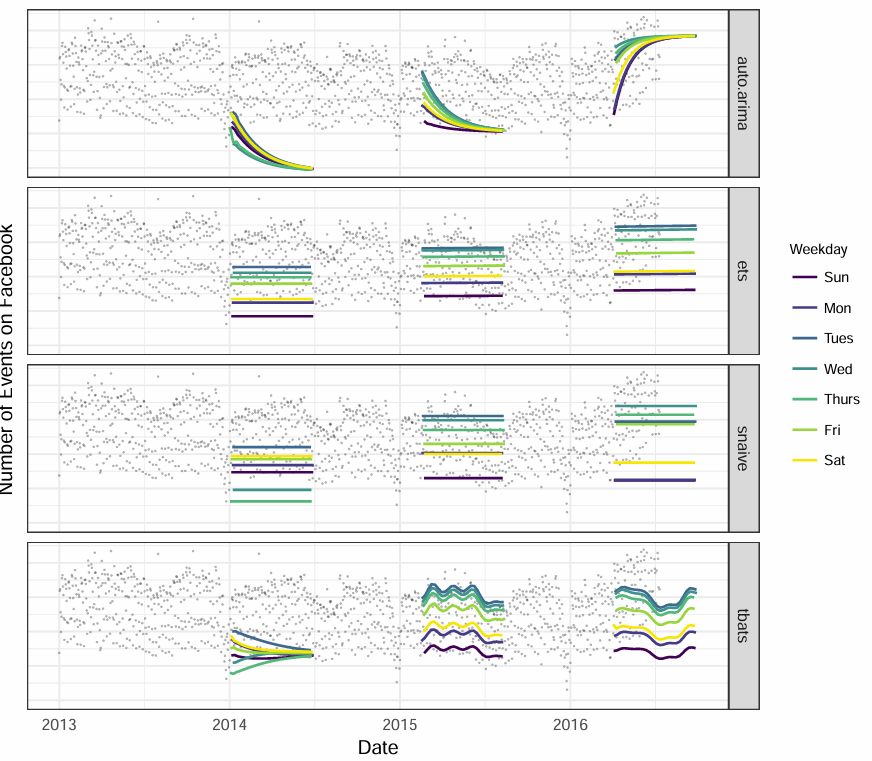

## Prophet model on same data

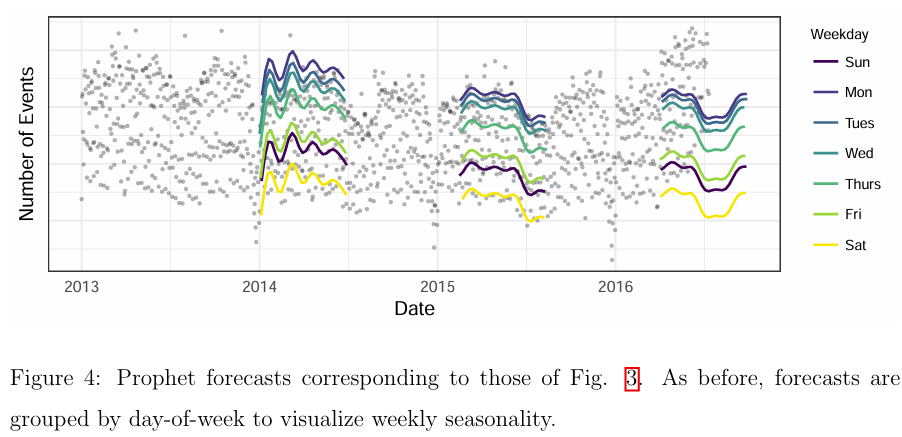

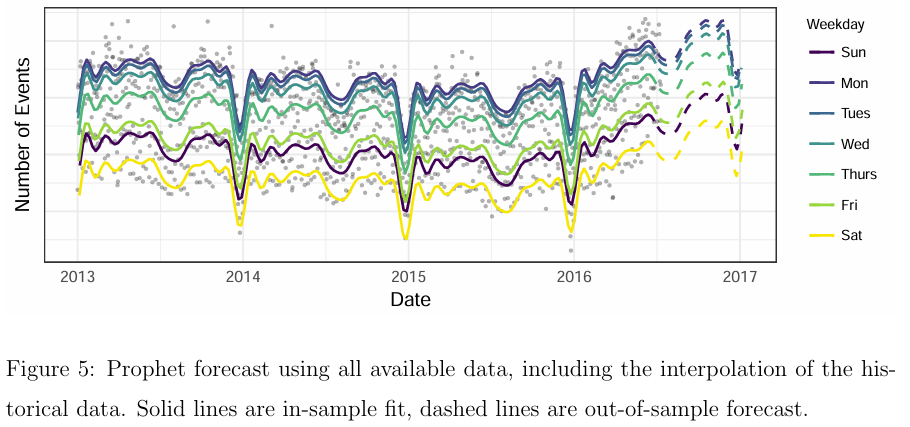

*(Taylor & Letham, 2017)*

## Optimizing the model:

We can change 4 factors to optimize the model:

1. **Capacities**- We might have external data for total market size, which can be used to set the capacity size.

2. **Changepoints**- We can customize the changepoints according to known events.

3. **Seasonality & Holidays**- We can add holidays and events to the model and customize the time scale of the seasonality.

4. **Smoothing Parameters**- We can adjust $\tau$ for selecting more global or local changepoints, $\nu, \sigma$ for smoothing the seasonality and holidays, which can control how much of the historical seasonal pattern is expected to be repeated in the future.